In [28]:
import pandas as pd

data = pd.read_csv('full_data_for_models.csv')
data.head()

,Crash Date/Time,Speed Limit,Crash Quarter,Crash Month,Crash DayOfWeek,Crash Hour,Is Holiday,Is Peak Hour,Is Weekend,Distance,Total Vehicles,Injury_Target,Vehicle Age
0,2015-01-01 00:30:00,35,1,1,3,0,1,0,0,14.88,2,0,7
1,2015-01-01 00:30:00,35,1,1,3,0,1,0,0,14.88,2,0,22
2,2015-01-01 01:10:00,40,1,1,3,1,1,0,0,1.64,2,0,8
3,2015-01-01 01:10:00,40,1,1,3,1,1,0,0,1.64,2,0,5
4,2015-01-01 01:14:00,40,1,1,3,1,1,0,0,10.48,2,2,13


In [29]:
data.drop(columns=['Crash Date/Time'], inplace=True)
data.head()

,Speed Limit,Crash Quarter,Crash Month,Crash DayOfWeek,Crash Hour,Is Holiday,Is Peak Hour,Is Weekend,Distance,Total Vehicles,Injury_Target,Vehicle Age
0,35,1,1,3,0,1,0,0,14.88,2,0,7
1,35,1,1,3,0,1,0,0,14.88,2,0,22
2,40,1,1,3,1,1,0,0,1.64,2,0,8
3,40,1,1,3,1,1,0,0,1.64,2,0,5
4,40,1,1,3,1,1,0,0,10.48,2,2,13


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172105 entries, 0 to 172104
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Speed Limit      172105 non-null  int64  
 1   Crash Quarter    172105 non-null  int64  
 2   Crash Month      172105 non-null  int64  
 3   Crash DayOfWeek  172105 non-null  int64  
 4   Crash Hour       172105 non-null  int64  
 5   Is Holiday       172105 non-null  int64  
 6   Is Peak Hour     172105 non-null  int64  
 7   Is Weekend       172105 non-null  int64  
 8   Distance         172105 non-null  float64
 9   Total Vehicles   172105 non-null  int64  
 10  Injury_Target    172105 non-null  int64  
 11  Vehicle Age      172105 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 15.8 MB


# Split the Data

In [31]:
from sklearn.model_selection import train_test_split

X = data.drop('Injury_Target', axis=1)
y = data['Injury_Target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dealing with Class Imbalance of the Training Set Only

In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

desired_samples = 30000

smote = SMOTE(sampling_strategy={1: desired_samples, 2: desired_samples, 3: desired_samples, 4: desired_samples})
under_sampler = RandomUnderSampler(sampling_strategy={0: desired_samples})

pipeline = Pipeline(steps=[
    ('over', smote),
    ('under', under_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Print the class distribution of the resampled training set
print("Training set class distribution:")
print(Counter(y_train_resampled))

# Print the class distribution of the test set
print("Test set class distribution:")
print(Counter(y_test))

Training set class distribution:
Counter({0: 30000, 1: 30000, 2: 30000, 3: 30000, 4: 30000})
Test set class distribution:
Counter({0: 28214, 1: 3553, 2: 2364, 3: 254, 4: 36})


# Train and Test the XGBoost Model

In [33]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_model.predict(X_test)

# Evaluate the model

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))

# classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.46061997036692715
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.50      0.63     28214
           1       0.13      0.31      0.18      3553
           2       0.09      0.21      0.12      2364
           3       0.02      0.19      0.03       254
           4       0.00      0.08      0.01        36

    accuracy                           0.46     34421
   macro avg       0.22      0.26      0.20     34421
weighted avg       0.72      0.46      0.55     34421



In [35]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Feature importances
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Confusion Matrix:
[[14215  6777  4474  2278   470]
 [ 1440  1094   634   299    86]
 [  912   657   496   240    59]
 [   77    67    57    47     6]
 [   12     5     9     7     3]]
            Feature  Importance
9    Total Vehicles    0.217451
6      Is Peak Hour    0.201741
0       Speed Limit    0.109036
5        Is Holiday    0.076438
1     Crash Quarter    0.074011
7        Is Weekend    0.069353
4        Crash Hour    0.059115
2       Crash Month    0.057043
10      Vehicle Age    0.047033
3   Crash DayOfWeek    0.044606
8          Distance    0.044173


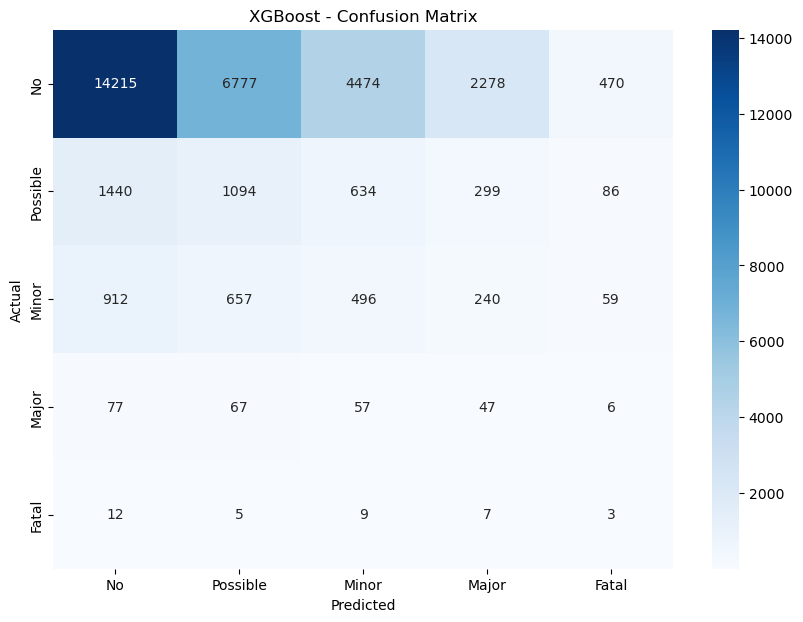

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Possible', 'Minor', 'Major', 'Fatal'], yticklabels=['No', 'Possible', 'Minor', 'Major', 'Fatal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost - Confusion Matrix')
plt.show()

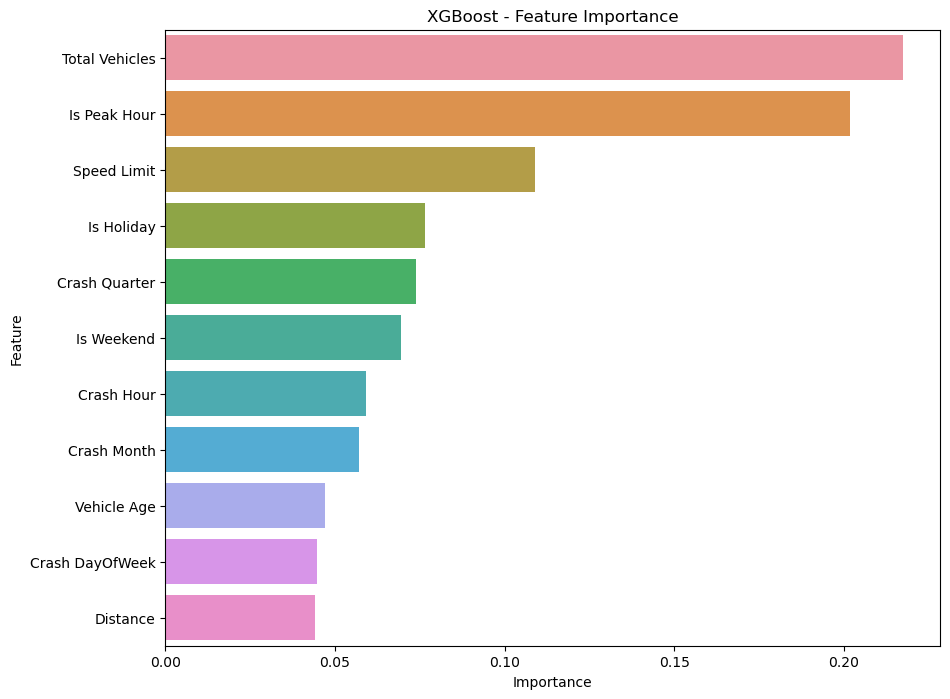

In [42]:
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is your training data DataFrame

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances})
    
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('XGBoost - Feature Importance')
plt.show()

ROC AUC Score (One-vs-Rest): 0.60
ROC AUC Score (One-vs-One): 0.60


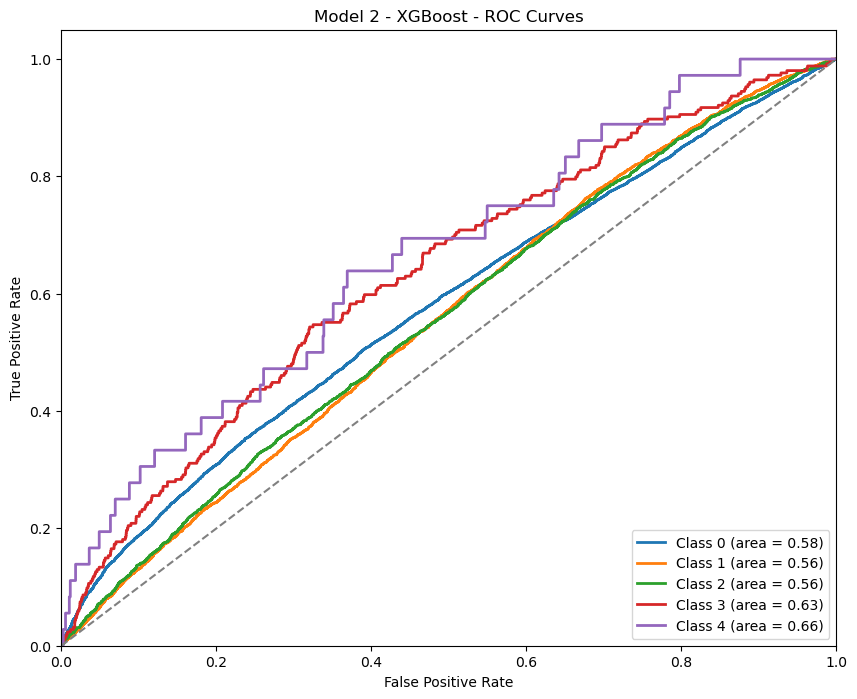

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

y_prob = xgb_model.predict_proba(X_test)

# Calculate the ROC AUC score with multi_class parameter
roc_auc_ovr = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')
roc_auc_ovo = roc_auc_score(y_test_binarized, y_prob, multi_class='ovo')
print(f'ROC AUC Score (One-vs-Rest): {roc_auc_ovr:.2f}')
print(f'ROC AUC Score (One-vs-One): {roc_auc_ovo:.2f}')

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc_score(y_test_binarized[:, i], y_prob[:, i]):.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 2 - XGBoost - ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [43]:
from sklearn.metrics import f1_score

y_true = y_test

f1 = f1_score(y_true, y_pred, average=None)
print("F1 Score for each class:", f1)

# Compute Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)

# Compute Weighted F1 score
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print("Weighted F1 Score:", weighted_f1)

# Compute Micro F1 score
micro_f1 = f1_score(y_true, y_pred, average='micro')
print("Micro F1 Score:", micro_f1)

F1 Score for each class: [0.6336082  0.18003785 0.12347523 0.03008    0.00909091]
Macro F1 Score: 0.1952584383139231
Weighted F1 Score: 0.5466476661647176
Micro F1 Score: 0.46061997036692715
